# 1 Успешность прототипа
Известно что компания конкурент выпустила 1000 прототипов игр, из которых было 5 успешных. Наша компания выпустила 200 прототипов из которых ни один не был успешен.
Какова вероятность что следующий (201й) наш прототип будет успешен? Решите задачу классическим и баесовским подходами.


In [1]:
#данные
n1, k1 = 1000, 5  #конкурент
n2, k2 = 200, 0   #мы

#классический
p_classic = (k1 + k2) / (n1 + n2)
print(f"{p_classic:.6f}")

#байесовский
alpha = 1 + k1
beta = 1 + n1 - k1
p_bayes = (alpha + k2) / (alpha + beta + n2)
print(f"{p_bayes:.6f}")

0.004167
0.004992


# 2 Сравнение групп платящих игроков
В мобильной игре около 10% игроков совершает платежи в первый месяц с момента установки игры (база расчета - 500 игроков). 
Геймдизайнеры разработали обновление которое по их экспертной оценке должно увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или опровергнуть их гипотезу.
Геймдизайнеры разработали обновление которое по их экспертной оценке должно увеличить процент плательщиков с 10% до 11%. Цель эксперимента - подтвердить или опровергнуть их гипотезу.
1.	Опишите оптимальный по вашему мнению дизайн эксперимента
2.	Рассчитайте длительность эксперимента при условии что каждый день в игру приходит около 100 новых игроков.
3.	Самостоятельно сгенерируйте датасет с около 10% плательщиков (контроль) и рассчитайте 95% HDI / CI.
4.	Сгенерируйте несколько вариантов экспериментальной группы (хуже, лучше, без эффекта), рассчитайте силу эффекта, HDI / CI и ваши выводы для каждого варианта.
5.	Решите задачу 2 разными подходами: frequentist / bayesian

Необходимо все ответы сопроводить комментариями почему вы выбрали ту или иную методику расчета, алгоритм и т.д.


In [ ]:
!pip install arviz

e:\project\yandex\.venv\Lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [102]:
import numpy as np
from scipy import stats
import statsmodels.stats.proportion as smp
import arviz as az #библиотека для байесовских операций

p_controlgr = 0.10          # конверсия в контроле
p_expectedgr = 0.11         # ожидаемая конверсия
alpha = 0.05              # уровень значимости
power = 0.8               # мощность
daily_users = 100         # новых игроков в день

In [103]:
#используем функцию из statsmodels для расчета размера выборки при сравнении двух пропорций
n_per_group = smp.samplesize_proportions_2indep_onetail(
    diff=p_controlgr-p_expectedgr, prop2=p_controlgr, alpha=alpha, power=power
)
n_per_group = int(np.ceil(n_per_group)) #игроков целое число

#длительность эксперимента: всего нужно 2 группы по n_per_group игроков
#новых игроков в день 100, поэтому делим общее количество на 100
days_needed = int(np.ceil(n_per_group * 2 / 100))
days_needed 
print(f"Необходимый размер выборки: {n_per_group}")
print(f"Дней на эксперимент: {days_needed}")

Необходимый размер выборки: 13495
Дней на эксперимент: 270


In [104]:
#генерация контрольной группы из 500 игроков с конверсией 10%
#np.random.binomial генерирует где 1 означает плательщика
n_control = 500
control_data = np.random.binomial(1, 0.10, n_control)

#расчет фактической конверсии и количества плательщиков
p_control = control_data.mean()
count_control = control_data.sum()

print(p_control)
print(count_control)

0.09
45


In [105]:
#частотный подход: 95% доверительный интервал
#используем метод proportion_confint
#метод для выборок больше 30
ci_freq = smp.proportion_confint(count=count_control, nobs=n_control, alpha=0.05, method='normal')

In [106]:
#байесовский подход 95% HDI с uniform prior Beta(1,1)
#генерируем 10000 выборок бета-распределения
p_samples = np.random.beta(a=1 + count_control, b=1 + n_control - count_control, size=10000)

#функция hdi() из библиотеки arviz для расчета HDI
hdi = az.hdi(p_samples, hdi_prob=0.95)

In [107]:
print(f"CI {ci_freq}")
print(f"HDI {hdi}")

CI (0.0649155236285527, 0.1150844763714473)
HDI [0.06711223 0.11705458]


In [161]:
#тест трех сценариев
scenarios = [(0.09, "Хуже"), (0.10, "Без эффекта"), (0.11, "Лучше")]
results = []

for exp_rate, label in scenarios:
    #500 игроков с заданной вероятностью платежа
    exp_data = np.random.binomial(1, exp_rate, 500)
    p_exp = exp_data.mean()  #конверсия в экспериментальной
    count_exp = exp_data.sum()  #количество плательщиков в экспериментальной

    #используем функцию z-тест пропорций потому что работаем с пропорциями, а не непрерывными величинами
    # two-sided - проверяем как улучшение, так и ухудшение
    counts = np.array([count_exp, count_control])
    nobs = np.array([500, n_control])
    z_stat, p_value = smp.proportions_ztest(counts, nobs, alternative='two-sided')
    
    #доверительный интервал для разницы пропорций
    #confint_proportions_2indep строит 95% доверительный интервал разницы двух пропорций
    ci_diff = smp.confint_proportions_2indep(count1=count_exp, nobs1=500, count2=count_control, nobs2=n_control)
    
    #байесовский подход
    #генерируем выборки из апостериорного распределения экспериментальной
    #использую бета-распределение beta(α=1+успехи, β=1+неудачи) с uniform prior beta(1,1)
    #Uniform prior выбран как неинформативный - не вносим предварительных предположений
    exp_samples = np.random.beta(a=1 + count_exp, b=1 + 500 - count_exp, size=10000)
    
    #вероятность того, что экспериментальная группа лучше контрольной
    #вычисляем долю случаев, когда случайная выборка из экспериментального распределения
    #больше случайной выборки из контрольного распределения
    prob_better = (exp_samples > p_samples).mean()
    
    #разница между выборками
    diff_samples = exp_samples - p_samples
    
    hdi_diff = az.hdi(diff_samples, hdi_prob=0.95)
    
    results.append({
        'Сенарий': label,                                   # название сценария
        'Конверсия': p_exp,                                 # фактическая конверсия в эксперименте
        'Разница': p_exp - p_control,                       # абсолютная разница конверсий
        'p_value': p_value,                                 # p-value частотного теста
        'CI разницы': [round(ci,6) for ci in ci_diff],      # 95% доверительный интервал разницы
        'Вероятность лучше': prob_better,                   # вероятность что эксперимент лучше
        'HDI разницы': [round(hdi,6) for hdi in hdi_diff]   # 95% HDI разницы
    })


In [162]:
import pandas as pd

df = pd.DataFrame(results)

In [163]:
df

,Сенарий,Конверсия,Разница,p_value,CI разницы,Вероятность лучше,HDI разницы
0,Хуже,0.080,-0.010,0.570744,"[-0.045071, 0.024947]",0.2816,"[-0.044765, 0.024628]"
1,Без эффекта,0.094,0.004,0.826788,"[-0.032208, 0.040248]",0.5851,"[-0.030387, 0.042261]"
2,Лучше,0.102,0.012,0.519532,"[-0.024834, 0.048942]",0.7337,"[-0.024855, 0.048523]"


На текущей базе в 500 игроков различия между контрольной и экспериментальной группами статистически незначимы во всех сценариях по frequentist-подходу: p-value существенно выше 0.05(при большинстве запусков), а 95% доверительные интервалы разницы конверсий включают ноль.
Байесовский анализ показывает рост апостериорной вероятности превосходства экспериментальной группы при увеличении конверсии, однако даже в лучшем сценарии неопределённость остаётся высокой, а HDI разницы всё ещё пересекает ноль.
Это означает, что при таком масштабе данных эффект порядка +1 п.п. надёжно не детектируется. Для подтверждения или опровержения гипотезы требуется больший объём выборки (≈13–15 тыс. игроков на группу) либо пересмотр эксперимента в сторону большего эффекта или альтернативных метрик.

# 3 Предсказание оттока
В мобильной игре, после установки и запуска игры начинается туториал - игрок проходит обучение игре, которое состоит из нескольких последовательных шагов. 
Данные представляют собой набор строк - уникальный id игрока, datetime и номер шага туториала который пройден игроком.
Геймдизайнеры выдвинули гипотезу - если мы с высокой вероятностью сможем предсказать шаг на котором игрок уйдет из игры заранее, то запустив альтернативное продолжение туториала с этого шага мы избежим оттока и увеличим прохождение туториала.
1.	Как бы вы решали задачу предсказания отвала игрока?
2.	Как оценить качество полученной модели? Опишите методы которые знаете и какой считаете оптимальным и почему.
3.	Предположим что вы разработали модель которая с достаточной вероятностью предсказывает отвал. Опишите дизайн эксперимента и методологию по проверке гипотезы геймдизайнеров



#### 1. Как бы вы решали задачу предсказания отвала игрока?
 Данные у нас по сути лог событий 

Цель - предсказать на каком этапе игрок дропнет туториал или вероятность отвала на до следующего шага

Определяем отвал как отсутствие следующего шага в течение N времени (например, 24 часа)

Даже из имеющейся информации мы можем извлечь достаточно информации для обучения модели
1. Временные признаки (из datetime):

- Время на каждом шаге = datetime текущего шага - datetime предыдущего шага
- Общее время в туториале = datetime текущего шага - datetime первого шага
- Время суток (час) прохождения шага (например если игрок в полночь лег спать а продолжил спустя 12 часов)
- День недели прохождения шага (в будни скорее всего играть будут меньше)

2. Признаки последовательности шагов (из step_number):

- Текущий номер шага
- Количество пройденных шагов
- Является ли шаг первым/последним в сессии

3. Признаки на уровне игрока (из агрегации по player_id):

- Среднее время на шаг
- Ускорение/замедление (изменение времени между последовательными шагами)
- Процент завершения туториала = текущий шаг / общее количество шагов

Для каждого игрока на каждом шаге предсказываем: "уйдет ли игрок после этого шага?"

Использовать оптимальнее всего модель градиентного бустинга так как они хорошо работают с табличными данными, категориальными признаками и дает важность признаков

#### 2.	Как оценить качество полученной модели? Опишите методы которые знаете и какой считаете оптимальным и почему.

Главная метрика  Precision-Recall AUC  либо F1-score, так как собитие отвала должно быть довольно редким явлением (если игроки отваливаются чаще это уже комплексная проблема самой игры)

PR-AUC хороша при дисбалансе классов, она показывает , насколько хорошо мы находим тех, кто уйдет

Precision@K: из K игроков, которых модель назвала рисковыми, сколько действительно ушли

Recall@K: сколько из всех ушедших мы нашли в топ-K

K выбираем исходя из бизнес-ограничений

F1-Score - Баланс между точностью и полнотой

#### 3. Дизайн эксперимента для проверки гипотезы

Гипотеза: Если показывать альтернативный туториал игрокам, которые по предсказанию модели уйдут, это увеличит прохождение туториала

Дизайн A/B-теста:

Разделение на группы:

* Контрольная: проходят стандартный туториал
* Тест: Модель в реальном времени оценивает вероятность отвала, если вероятность выше порога - показывается альтернативный туториал

Разделяем рандомно по id со стратификацией по времени суток

Основные метрики:

Главная: Процент дошедших до конца туториала
Сопутствующие: возвращаемость, среднее время прохождениия

Размер и продолжительность эксперимента зависят от желаемого эффекта и текущего байзлайна

Для проверки результатов используем t-test и ROI


# 4 Эффективность рекламных кампаний
Отдел маркетинга оперирует некоторым множеством рекламных кампаний. Первая часть оперирования состоит из запуска тестовых рекламных кампаний, у которых есть требования по KPI при достижении которых тест считается успешным.
Успешные тесты переходят в разряд постоянных кампаний и вторая часть оперирования состоит из мониторинга постоянных кампаний - управление бюджетом кампании (COST) и мониторинг ее доходов (REVENUE), а так же соотношением доходов к расходам.
Главный KPI для постоянных рекламных кампаний - ROAS на 60й день, т.е. какой процент от расходов кампания возвращает на 60й день.
Для выполнения задачи необходимо использовать тестовый датасет (2 таблицы по расходам и доходам).
1.	Отдел маркетинга руководствуется гипотезой - чем больший COST расходуется на кампанию тем ниже ROAS 60го дня (рост CPI при увеличении объёма закупки при сохранении того же LTV 60го дня). На основании данных подтвердите или опровергните эту гипотезу. Исходите из того что мы точно знаем что CPI зависит от объема нелинейно, вопрос в том как эту зависимость описать и учесть во 2м вопросе.
2.	По каждой рекламной кампании рассчитайте суточный рекламный бюджет который максимизирует абсолютную маркетинговую прибыль рекламной кампании (REVENUE 60 дня минус COST).
3.	Исходя из пункта 2 по каждой рекламной кампании дайте ваше заключение о том насколько нужно увеличить / уменьшить ее суточный бюджет либо вообще остановить.
4.	Решите проблему рекламных кампаний по которым еще нет полных 60 дней. Объясните почему ваше решение оптимально


In [97]:
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats

conn = sqlite3.connect('testcase (1).db')
costs = pd.read_sql_query('SELECT * FROM costs', conn)
revenue = pd.read_sql_query('SELECT * FROM revenue', conn)
conn.close()

In [98]:
revenue = revenue.dropna().drop_duplicates()
costs = costs.dropna().drop_duplicates()

In [99]:
print("Размер costs:", costs.shape)
print("Размер revenue:", revenue.shape)

Размер costs: (9926, 5)
Размер revenue: (9923, 9)


In [100]:
key_cols = ['Install_Dates', 'campaign_id', 'Country']

costs_duplicates = costs.duplicated(subset=key_cols, keep=False)
print(f"Дубликатов в costs: {costs_duplicates.sum()}")

costs = costs.drop_duplicates(subset=key_cols)

#revenue дубликаты с разными LTV усредняем
revenue_grouped = revenue.groupby(key_cols).mean().reset_index()
print(f"После агрегации revenue: {revenue_grouped.shape[0]} строк")

Дубликатов в costs: 268
После агрегации revenue: 9792 строк


In [101]:
df = pd.merge(
    costs,
    revenue_grouped,
    on=key_cols,
    how='inner'
)
df.shape[0]

9792

In [102]:
df['CPI'] = df['spends'] / df['installs'].replace(0, np.nan)
df['CPI'] = df['CPI'].replace([np.inf, -np.inf], np.nan)

In [103]:
for hor in ['1d', '3d', '7d', '14d', '30d', '60d']:
    ltv_col = f'{hor}_LTV'
    roas_col = f'ROAS_{hor}'
    df[roas_col] = df[ltv_col] / df['CPI'].replace(0, np.nan)
    df[roas_col] = df[roas_col].replace([np.inf, -np.inf], np.nan)

In [104]:
df

,Install_Dates,campaign_id,Country,installs,spends,1d_LTV,3d_LTV,7d_LTV,14d_LTV,30d_LTV,60d_LTV,CPI,ROAS_1d,ROAS_3d,ROAS_7d,ROAS_14d,ROAS_30d,ROAS_60d
0,2020-04-14,90570,CZ,35.0,19.79,7.721194,8.104811,10.209480,11.845200,15.349594,15.768420,0.565429,13.655472,14.333925,18.056180,20.949065,27.146831,27.887555
1,2020-04-28,90619,AT,5.0,4.99,1.032342,1.032342,1.248888,1.501317,1.761729,-1.000000,0.998000,1.034411,1.034411,1.251391,1.504326,1.765260,-1.002004
2,2020-05-10,794235,PK,79.0,0.40,0.212500,0.254620,0.390186,0.519535,0.652006,-1.000000,0.005063,41.968750,50.287447,77.061735,102.608162,128.771185,-197.500000
3,2020-05-07,91872,FR,12.0,9.56,4.661390,4.787784,6.422362,6.596973,6.596973,-1.000000,0.796667,5.851117,6.009771,8.061542,8.280719,8.280719,-1.255230
4,2020-04-03,19115,JP,6.0,3.39,0.833442,0.833442,1.103046,1.167516,1.398647,1.416652,0.565000,1.475119,1.475119,1.952294,2.066400,2.475481,2.507349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9787,2020-04-02,90464,UN,0.0,0.45,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9788,2020-04-27,19115,DE,27.0,21.33,31.003103,36.859179,45.552113,52.804398,58.205993,-1.000000,0.790000,39.244434,46.657189,57.660902,66.841010,73.678472,-1.265823
9789,2020-03-27,159253,DK,2.0,0.19,0.351962,0.351962,0.386234,0.448579,0.564261,0.693104,0.095000,3.704863,3.704863,4.065621,4.721884,5.939589,7.295832
9790,2020-04-12,790034,RU,534.0,81.06,47.323662,56.483875,65.396237,75.178386,85.603100,92.690140,0.151798,311.754694,372.099548,430.811628,495.253616,563.928638,610.616021


In [ ]:
#-1.0 на NaN в 60d_LTV 
df['60d_LTV'] = df['60d_LTV'].replace(-1.0, np.nan)

In [113]:
# 1. Проверка гипотезы: чем больше COST, тем ниже ROAS60

campaign_df = df.groupby('campaign_id').agg({
    'spends': 'sum',
    'installs': 'sum',
    'CPI': 'mean',
    'ROAS_60d': 'mean',
    'ROAS_30d': 'mean', 
    '30d_LTV': 'mean',
    'Install_Dates': 'nunique'
}).reset_index()

campaign_df = campaign_df.rename(columns={'Install_Dates': 'num_days'})
campaign_df['daily_spend'] = campaign_df['spends'] / campaign_df['num_days'].replace(0, np.nan)

campaign_df['daily_profit'] = campaign_df['daily_spend'] * (campaign_df['ROAS_60d'] - 1)
campaign_df['daily_profit'] = campaign_df['daily_profit'].clip(lower=0)

In [116]:
valid = campaign_df[campaign_df['ROAS_60d'].notna() & (campaign_df['spends'] > 0)]

corr_spend_roas = valid['spends'].corr(valid['ROAS_60d'])
corr_install_cpi = valid['installs'].corr(valid['CPI'])

print(f"Корреляция spends ↔ ROAS60:          {corr_spend_roas:.3f}")
print(f"Корреляция installs ↔ средний CPI:   {corr_install_cpi:.3f}")

# Линейная регрессия log(CPI) ~ log(spends)
slope, intercept, r_value, p_value, _ = stats.linregress(
    np.log1p(valid['spends']),
    np.log1p(valid['CPI'].replace(0, np.nan))
)
print(f"  Коэффициент наклона: {slope:.3f} (если <0 - CPI падает с ростом объёма)")
print(f"  p-value:             {p_value:.4f}")

if corr_spend_roas > 0:
    print("Гипотеза опровергнута: большие бюджеты коррелируют с выше ROAS60")
elif corr_spend_roas < -0.1:
    print("Гипотеза подтверждена: большие бюджеты → ниже ROAS60")
else:
    print("Гипотеза не подтверждается: зависимость слабая или отсутствует")

Корреляция spends ↔ ROAS60:          0.420
Корреляция installs ↔ средний CPI:   -0.101
  Коэффициент наклона: 0.067 (если <0 - CPI падает с ростом объёма)
  p-value:             0.0000
Гипотеза опровергнута: большие бюджеты коррелируют с выше ROAS60


Вывод по гипотезе «чем больший COST, тем ниже ROAS60 (из-за роста CPI при масштабе)» — гипотеза полностью опровергнута.

Положительная корреляция spends - ROAS60: Большие бюджеты не снижают, а наоборот — сильно ассоциированы с более высоким ROAS на 60-й день. Это противоположно гипотезе.

Слабая отрицательная корреляция installs - CPI: Больший объём закупки слегка снижает средний CPI (экономия на масштабе), а не повышает. Это тоже противоречит гипотезе о росте CPI при увеличении объёма.

Общий итог по зависимости CPI от объёма:

Зависимость существует, но слабая и положительная (CPI слегка растёт с масштабом).


Однако этот рост не компенсируется падением LTV — напротив, ROAS растёт с бюджетом.

In [117]:
campaign_df['daily_profit'] = campaign_df['daily_spend'] * (campaign_df['ROAS_60d'] - 1)
campaign_df['daily_profit'] = campaign_df['daily_profit'].clip(lower=0)

In [118]:
def get_recommendation(row):
    roas = row['ROAS_60d']
    is_proxy = pd.isna(roas)
    if is_proxy:
        roas = row['ROAS_30d']
        proxy_note = " (по ROAS30 как прокси)"
    else:
        proxy_note = ""
    if pd.isna(roas) or roas is None:
        return "Нет достаточных данных даже по 30d — мониторить дальше"
    if roas <= 0:
        return "Остановить немедленно (отрицательный ROAS — проверить данные!)"
    if roas < 1:
        return "Остановить (убыточная кампания)"
    if roas < 5:
        scale = min(3.0, roas * 1.5)
        msg = "Умеренно увеличить"
    elif roas < 20:
        scale = min(8.0, roas / 3)
        msg = "Значительно увеличить"
    elif roas < 100:
        scale = min(15.0, roas / 10)
        msg = "Сильно масштабировать"
    else:
        scale = min(30.0, np.log1p(roas) * 2)
        msg = "Агрессивно масштабировать (топ-кампания)"

    return f"{msg} *{scale:.1f} или до лимита{proxy_note}"

campaign_df['recommendation'] = campaign_df.apply(get_recommendation, axis=1)

campaign_df['optimal_daily_budget'] = np.where(
    (campaign_df['ROAS_60d'] > 1) | (campaign_df['ROAS_30d'] > 1),
    campaign_df['daily_spend'] * np.minimum(30, np.log1p(campaign_df['ROAS_60d'].fillna(campaign_df['ROAS_30d'])) * 2),
    0
)

print("\nТоп-10 по ожидаемой прибыли:")
top_profit = campaign_df[campaign_df['ROAS_60d'].fillna(campaign_df['ROAS_30d']) > 1].sort_values('daily_profit', ascending=False).head(10)
print(top_profit[['campaign_id', 'spends', 'installs', 'ROAS_60d', 'ROAS_30d', 'daily_spend', 'daily_profit', 'recommendation', 'optimal_daily_budget']].round(2))

print("\nКампании с ROAS ≤ 1 (остановить):")
losers = campaign_df[campaign_df['ROAS_60d'].fillna(campaign_df['ROAS_30d']) <= 1].sort_values('ROAS_60d')
print(losers[['campaign_id', 'spends', 'installs', 'ROAS_60d', 'ROAS_30d', 'daily_spend', 'recommendation']].round(2))


Топ-10 по ожидаемой прибыли:
     campaign_id    spends  installs  ROAS_60d  ROAS_30d  daily_spend  \
177       790034  12076.27   87544.0   1947.00   1877.23       223.63   
77        160845  16038.87   87603.0    964.67   1921.67       271.85   
209       792044   1304.47    1968.0    278.34    264.35       108.71   
227       803588   1326.48   14052.0    542.13    476.52        49.13   
0          19115  29175.69   85780.0     46.89     69.82       478.29   
183       790523    242.98    2229.0    574.38    523.61        27.00   
193       790778   2581.29   20954.0    171.33    572.40        60.03   
108       787274   2914.16    6235.0    103.36    151.24        56.04   
58         94692   2625.96    7318.0     89.96    153.04        46.07   
94        786714   1393.14   12375.0    133.09    320.36        30.96   

     daily_profit                                     recommendation  \
177     435193.72  Агрессивно масштабировать (топ-кампания) *15.1...   
77      261970.36  Агр

e:\project\yandex\.venv\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [120]:
# Пункт 4 обработка кампаний без 60d

no_60d = campaign_df[campaign_df['ROAS_60d'].isna()]

print(f"Найдено кампаний без ROAS60: {len(no_60d)}")
if not no_60d.empty:
    print("\nиспользуем ROAS30 как прокси:")
    print(no_60d[['campaign_id', 'spends', 'installs', 'num_days', 'ROAS_30d', 'daily_spend', 'recommendation', 'optimal_daily_budget']].round(2))
else:
    print("Все кампании имеют ROAS60")

#Почему ROAS30 оптимальный прокси:
#1. 30d_LTV захватывает 70-90% lifetime value (рост после 30 дней обычно 10-30%)
#2. Консервативно: если ROAS30 >1.2  ROAS60 почти наверняка >1
#3. Лучше остановить рано убыточные, чем ждать 60 дней и потерять бюджет
#4. Альтернативы слишком рано, экстраполяция рискованно без retention-данных

Найдено кампаний без ROAS60: 9

используем ROAS30 как прокси:
     campaign_id   spends  installs  num_days  ROAS_30d  daily_spend  \
69         98168     0.30       0.0         1       NaN         0.30   
96        786909     7.92       0.0         8       NaN         0.99   
123       788070     7.15       0.0         8       NaN         0.89   
130       788248    92.52       0.0        19       NaN         4.87   
172       789602  4477.87       0.0        14       NaN       319.85   
206       791913   297.92       0.0        14       NaN        21.28   
214       792342    40.55       0.0        13       NaN         3.12   
216       793773     7.34       0.0         8       NaN         0.92   
228       804309     0.40       0.0         2       NaN         0.20   

                                        recommendation  optimal_daily_budget  
69   Нет достаточных данных даже по 30d — мониторит...                   0.0  
96   Нет достаточных данных даже по 30d — мониторит...     

# 5 Связь рекламного траффика и органического

In [125]:
conn = sqlite3.connect('testcase (1).db')
df = pd.read_sql_query('SELECT * FROM source_comparison', conn)
conn.close()

In [126]:

import matplotlib.pyplot as plt 
from statsmodels.tsa.statespace.sarimax import SARIMAX  
from statsmodels.tsa.stattools import grangercausalitytests 
from statsmodels.tsa.stattools import adfuller  

%matplotlib inline

In [127]:
df['Install_Dates'] = pd.to_datetime(df['Install_Dates'])

In [128]:
df.head()

,Install_Dates,source_type,Country,installs
0,2020-05-18,Paid,PY,4.0
1,2020-04-14,Paid,FR,35.0
2,2020-04-30,Paid,JP,25.0
3,2020-03-20,Paid,DE,11.0
4,2020-04-30,Paid,IT,8.0


In [129]:
daily_data = df.groupby(['Install_Dates', 'source_type'])['installs'].sum().unstack()
daily_data.columns = ['Organic', 'Paid']
daily_data['Total'] = daily_data['Organic'] + daily_data['Paid']

daily_data.head()

,Organic,Paid,Total
Install_Dates,,,
2020-03-18,8961.0,7359.0,16320.0
2020-03-19,8457.0,6739.0,15196.0
2020-03-20,8819.0,7254.0,16073.0
2020-03-21,4485.0,9552.0,14037.0
2020-03-22,5105.0,14804.0,19909.0


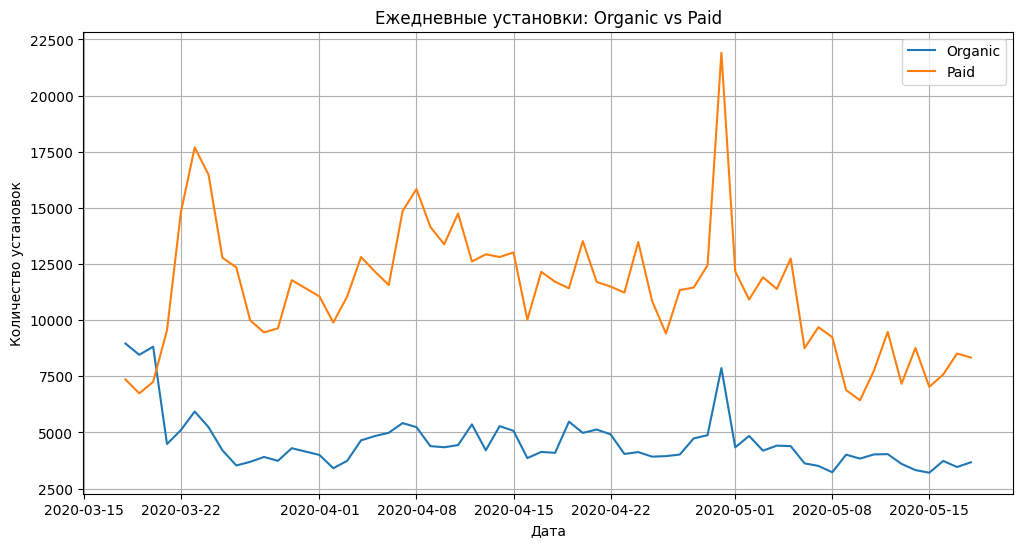

In [130]:
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['Organic'], label='Organic')
plt.plot(daily_data.index, daily_data['Paid'], label='Paid')
plt.title('Ежедневные установки: Organic vs Paid')
plt.xlabel('Дата')
plt.ylabel('Количество установок')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
#Используем тест Augmented Dickey-Fuller (ADF)

def adf_test(series, title=''):
    result = adfuller(series)
    print(f'\nADF тест для {title}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Ряд стационарен")
    else:
        print("Ряд нестационарен")

# Organic
adf_test(daily_data['Organic'], 'Organic')

# Paid
adf_test(daily_data['Paid'], 'Paid')


ADF тест для Organic:
ADF Statistic: -4.533345492745276
p-value: 0.00017108657038093197
Ряд стационарен

ADF тест для Paid:
ADF Statistic: -3.019268842247756
p-value: 0.03313369693937274
Ряд стационарен


In [134]:
#Корреляция между Organic и Paid
correlation = daily_data['Organic'].corr(daily_data['Paid'])
print(f'Organic и Paid: {correlation:.4f}')

Organic и Paid: 0.2243


In [137]:
print("\nТест Гренджера: Does Paid Granger-cause Organic?")
granger_test = grangercausalitytests(daily_data[['Organic', 'Paid']], maxlag=5, verbose=True)

# если p-value < 0.05 для какого-то лага, то есть причинность


Тест Гренджера: Does Paid Granger-cause Organic?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4036  , p=0.5278  , df_denom=57, df_num=1
ssr based chi2 test:   chi2=0.4248  , p=0.5145  , df=1
likelihood ratio test: chi2=0.4233  , p=0.5153  , df=1
parameter F test:         F=0.4036  , p=0.5278  , df_denom=57, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1652  , p=0.8482  , df_denom=54, df_num=2
ssr based chi2 test:   chi2=0.3609  , p=0.8349  , df=2
likelihood ratio test: chi2=0.3598  , p=0.8353  , df=2
parameter F test:         F=0.1652  , p=0.8482  , df_denom=54, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6433  , p=0.1909  , df_denom=51, df_num=3
ssr based chi2 test:   chi2=5.6066  , p=0.1324  , df=3
likelihood ratio test: chi2=5.3519  , p=0.1478  , df=3
parameter F test:         F=1.6433  , p=0.1909  , df_denom=51, df_num=3

Granger Causality
number of lags (no zero) 4
ssr 

e:\project\yandex\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [136]:
model = SARIMAX(daily_data['Organic'], 
                exog=daily_data['Paid'], 
                order=(1,1,1), 
                seasonal_order=(0,0,0,0))

results = model.fit()

# Вывод сводки модели
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Organic   No. Observations:                   61
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -489.235
Date:                Thu, 05 Feb 2026   AIC                            986.470
Time:                        14:24:43   BIC                            994.847
Sample:                             0   HQIC                           989.747
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Paid           0.1899      0.041      4.686      0.000       0.110       0.269
ar.L1         -0.9960      0.073    -13.716      0.000      -1.138      -0.854
ma.L1          0.9830      0.176      5.594      0.0

e:\project\yandex\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\project\yandex\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


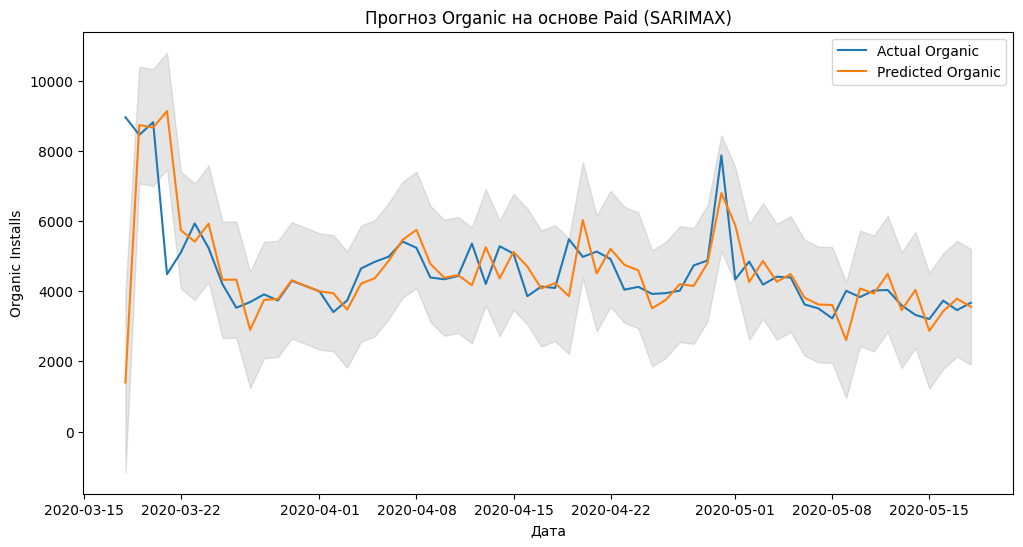

In [139]:
#прогноз на существующих данных
forecast = results.get_prediction(exog=daily_data['Paid'])
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data['Organic'], label='Actual Organic')
plt.plot(daily_data.index, forecast_mean, label='Predicted Organic')
plt.fill_between(daily_data.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], color='gray', alpha=0.2)
plt.title('Прогноз Organic на основе Paid (SARIMAX)')
plt.xlabel('Дата')
plt.ylabel('Organic Installs')
plt.legend()
plt.show()

Модель SARIMAX показывает значимую положительную зависимость Organic от Paid: коэффициент = 0.1899 с p-value = 0.000 (меньше 0.05). Это указывает на то, что в среднем на каждую дополнительную единицу Paid приходится около 0.19 единиц Organic

Корреляция между Organic и Paid составляет 0.2243, что указывает на слабую положительную линейную связь. Это не опровергает гипотезу, но и не сильно ее поддерживает.

Во всех лаговых тестах (от 1 до 5) p-values > 0.05 (например, для 1 лага: p=0.5278; для 3 лагов: p=0.1909; для 5 лагов: p=0.8702). Это означает, что нет статистически значимой Granger-причинности: прошлые значения Paid не помогают предсказывать Organic лучше, чем только прошлые значения Organic. Таким образом, нет доказательств, что рост Paid причиняет рост Organic в смысле временной предсказуемости.

Гипотеза маркетологов опровергнута в части причинно-следственной связи. Хотя в SARIMAX наблюдается положительная ассоциация (возможно, одновременная корреляция или влияние общих факторов), тест Гренджера не подтверждает, что рекламный трафик вызывает органический. Слабая корреляция также не дает сильных аргументов в пользу гипотезы.

Возможно, связь обратная — органический трафик влияет на рекламный (например, через общую популярность продукта), или оба зависят от внешних факторов (сезонность, события)

In [141]:

daily_data = df.groupby(['Install_Dates', 'source_type'])['installs'].sum().unstack().fillna(0)
daily_data.columns = ['Organic', 'Paid']

print("Granger Causality Test: Does Organic Granger-cause Paid?")
granger_test_reverse = grangercausalitytests(daily_data[['Paid', 'Organic']], maxlag=5, verbose=True)

Granger Causality Test: Does Organic Granger-cause Paid?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0439  , p=0.8347  , df_denom=57, df_num=1
ssr based chi2 test:   chi2=0.0463  , p=0.8297  , df=1
likelihood ratio test: chi2=0.0462  , p=0.8297  , df=1
parameter F test:         F=0.0439  , p=0.8347  , df_denom=57, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9938  , p=0.3768  , df_denom=54, df_num=2
ssr based chi2 test:   chi2=2.1716  , p=0.3376  , df=2
likelihood ratio test: chi2=2.1326  , p=0.3443  , df=2
parameter F test:         F=0.9938  , p=0.3768  , df_denom=54, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3377  , p=0.0845  , df_denom=51, df_num=3
ssr based chi2 test:   chi2=7.9758  , p=0.0465  , df=3
likelihood ratio test: chi2=7.4730  , p=0.0583  , df=3
parameter F test:         F=2.3377  , p=0.0845  , df_denom=51, df_num=3

Granger Causality
number of lags (no zero)

e:\project\yandex\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Таким образом, есть слабые доказательства причинности на лаге 3 (p<0.05 в chi2), но не во всех тестах. Гипотеза частично подтверждается, но не сильно (вероятность ~95% для лага 3).